In [2]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score, roc_curve,auc
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
employee_data = pd.read_excel("Employee_Absent_Data.xlsx", sheet_name = 'Sheet1')

After looking into data a bit more via excel, Here are few things which I have noticed,
- This data only keep the information when employee was on leave/absent (hence the rows with 0 absent hours represents some of days when).
- There is primarily 3 type of information(features)
    - ID level - unique to a person which is same all across the data
    - attribute across month - Season
    - Variables  with 3 values for each- which roughly translates to 3 years of data

Also you have rows in the data where everthing is same across 2 rows except absent hours, which means either record was added every time someone took/applied for leave or aggregated at an year level and later year is not provided in the data. leave hours are in multiple of 8 post 4, hence I assume <=4 hours >> half-day leave and 8 hours >> 1 day leave. if you look at max number of hours, i.e. 120 = 15 days, because you can't have 15 week in one months, hence I am assuming he applied leave for 15 working days.

For purpose of this classification problem I am gonna assume that all the employees were in the firm for whole period the data was collected for. And half day is also a leave because work will get impacted.

### Data prep

For the records where absent hours = 0, i am assuming that leave was applied but not approved just to keep the info of the employees, who have never applied for leave. There are few additoinal employees with such info. There is only one duplicate in terms employee level info across Id I am gonna remove one with smaller record (one record), i.e. ID 29.

In [4]:
employee_data[['ID','Commute_cost', 'Distance_from_Office_to_Work',
       'Service_time', 'Age', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index',]].drop_duplicates().groupby('ID').size().loc[lambda x: x >1]

ID
29    2
dtype: int64

In [5]:
employee_data.query('ID == 29').groupby(['ID','Age']).size()

ID  Age
29  28     1
    41     4
dtype: int64

In [6]:
employee_data_n = employee_data[~((employee_data['ID']==29)&(employee_data['Age']==28))]
print(len(employee_data),len(employee_data_n))

740 739


Assuming 8 hours represent one day off, anything between 1 to 8 I will still consider this a leave as employee is on partial leave. Anything greater than 8 represents leavees in coming days, We know we have these hours in multiple of 8 wherever it is >8

In [7]:
empl_absent_info_multi_day = employee_data_n[employee_data_n['Absent_time_hours']>8].reset_index()
all_absent_ = pd.DataFrame()
t = [2,3,4,5,6,]*50
for i in range(len(empl_absent_info_multi_day)):
    n_days = int(empl_absent_info_multi_day.iloc[i]['Absent_time_hours']/8)
    start = int(empl_absent_info_multi_day.iloc[i]['Day_of_the_week'])
    te = pd.concat([empl_absent_info_multi_day.iloc[[i]]]* n_days)
    te['Day_of_the_week'] = t[start-2: start-2+n_days]
    all_absent_= pd.concat([all_absent_,te.drop(['Absent_time_hours','index'], axis = 1)],ignore_index=True)
empl_absent_info_1day = employee_data_n[employee_data_n['Absent_time_hours'].between(1,8)]
all_absent_ = pd.concat([all_absent_,empl_absent_info_1day.drop('Absent_time_hours', axis = 1)],ignore_index=True)
all_absent_['Absent_flag'] = 1
all_absent_

,ID,Absence_Reason,Month_of_absence,Day_of_the_week,Seasons,Commute_cost,Distance_from_Office_to_Work,Service_time,Age,Work_load_Average_per_day,...,Disciplinary_failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absent_flag
0,14,19,7,2,1,155,12,14,34,239554,...,0,1,2,1,0,0,95,196,25,1
1,14,19,7,3,1,155,12,14,34,239554,...,0,1,2,1,0,0,95,196,25,1
2,14,19,7,4,1,155,12,14,34,239554,...,0,1,2,1,0,0,95,196,25,1
3,14,19,7,5,1,155,12,14,34,239554,...,0,1,2,1,0,0,95,196,25,1
4,14,19,7,6,1,155,12,14,34,239554,...,0,1,2,1,0,0,95,196,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,34,23,7,4,1,118,10,10,37,264604,...,0,1,0,0,0,0,83,172,28,1
934,10,22,7,4,1,361,52,3,28,264604,...,0,1,1,1,0,4,80,172,27,1
935,28,22,7,4,1,225,26,9,28,264604,...,0,1,1,0,0,2,69,169,24,1
936,11,14,7,3,1,289,36,13,33,264604,...,0,1,2,1,0,1,90,172,30,1


In [8]:
employee_data_n.columns

Index(['ID', 'Absence_Reason', 'Month_of_absence', 'Day_of_the_week',
       'Seasons', 'Commute_cost', 'Distance_from_Office_to_Work',
       'Service_time', 'Age', 'Work_load_Average_per_day', 'Hit_target',
       'Disciplinary_failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index',
       'Absent_time_hours'],
      dtype='object')

In [9]:
empl_info = employee_data_n[['ID','Commute_cost', 'Distance_from_Office_to_Work','Service_time', 'Age', 'Education', 'Son',
                   'Social drinker','Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']].drop_duplicates()
print(len(empl_info))
empl_info

36


,ID,Commute_cost,Distance_from_Office_to_Work,Service_time,Age,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index
0,11,289,36,13,33,1,2,1,0,1,90,172,30
1,36,118,13,18,50,1,1,1,0,0,98,178,31
2,3,179,51,18,38,1,0,1,0,0,89,170,31
3,7,279,5,14,39,1,2,1,1,0,68,168,24
6,10,361,52,3,28,1,1,1,0,4,80,172,27
7,20,260,50,11,36,1,4,1,0,0,65,168,23
8,14,155,12,14,34,1,2,1,0,0,95,196,25
9,1,235,11,14,37,3,1,0,0,1,88,172,29
15,24,246,25,16,41,1,0,1,0,0,67,170,23
18,6,189,29,13,33,1,2,0,0,2,69,167,25


<!-- There is a duplicate in the data at id level for discipinary action, which means at some point of there was action before that there wasn't much disciplinary action -->
Let's look  at some info which are duplicated at month level which is consisted with the years of data we have, hence we have to assume some years for each of them

In [10]:
temp_m_data = employee_data_n[['Month_of_absence','Work_load_Average_per_day','Hit_target']].drop_duplicates().sort_values('Month_of_absence')
temp_m_data['Year'] = temp_m_data.groupby(['Month_of_absence']).cumcount() + 2007
temp_m_data['Year'] =temp_m_data.apply(lambda row : 2010 if ((row['Month_of_absence'] <7) and (row['Year'] == 2007)) else row['Year'], axis = 1)
temp_m_data = temp_m_data[temp_m_data['Month_of_absence']> 0]
temp_m_data

,Month_of_absence,Work_load_Average_per_day,Hit_target,Year
570,1,313532,96,2010
113,1,308593,95,2008
358,1,330061,100,2009
137,2,302585,99,2010
585,2,264249,97,2008
369,2,251818,96,2009
390,3,244387,98,2010
155,3,343253,95,2008
618,3,222196,99,2009
184,4,326452,96,2010


In [11]:
# Create 3 years of dates
dates = pd.DataFrame()
dates['dates'] = pd.date_range(start='2007-07-01', end='2010-07-31',freq='d')
dates['Month_of_absence'] = dates['dates'].apply(lambda x : x.month)
dates['Year'] = dates['dates'].apply(lambda x : x.year)
dates['Day_of_the_week'] = dates['dates'].apply(lambda x : x.weekday())
dates['Day_of_the_week__'] = dates['dates'].apply(lambda x : x.day_name())
dates = dates[dates['Day_of_the_week']< 5]
dates['Day_of_the_week'] = dates['Day_of_the_week'] +2

In [12]:
date_level = pd.merge(dates,temp_m_data, on=['Year','Month_of_absence'], how = 'inner')

In [13]:
empl_all_dates = pd.merge(empl_info,date_level,how ='cross')

In [15]:
all_absent_['row_c'] = all_absent_.groupby(['ID','Month_of_absence','Day_of_the_week','Work_load_Average_per_day']).cumcount() +1
all_absent_['key'] = all_absent_[['ID','Month_of_absence','Day_of_the_week','Work_load_Average_per_day','row_c']].astype(str).agg('-'.join, axis=1)

In [16]:
empl_all_dates['row_c'] = empl_all_dates.groupby(['ID','Month_of_absence','Day_of_the_week','Work_load_Average_per_day']).cumcount() +1
empl_all_dates['key'] = empl_all_dates[['ID','Month_of_absence','Day_of_the_week','Work_load_Average_per_day','row_c']].astype(str).agg('-'.join, axis=1)

In [17]:
final_data = pd.merge(empl_all_dates,all_absent_[['key','Absence_Reason','Absent_flag']], how = 'left', on ='key')
final_data['Absent_flag'] = final_data['Absent_flag'].fillna(0)
final_data = final_data.drop(['row_c','Day_of_the_week__','dates','Year','key'],axis = 1)

In [18]:
# cyclic encoding for month
def encode_month(data, col, max_val = 12):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

final_data = encode_month(final_data, 'Month_of_absence')
final_data = final_data.drop('Month_of_absence',1)
final_data= pd.get_dummies(final_data, prefix=['DOW'], columns=['Day_of_the_week'])

In [19]:
final_data.columns

Index(['ID', 'Commute_cost', 'Distance_from_Office_to_Work', 'Service_time',
       'Age', 'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet',
       'Weight', 'Height', 'Body mass index', 'Work_load_Average_per_day',
       'Hit_target', 'Absence_Reason', 'Absent_flag', 'Month_of_absence_sin',
       'Month_of_absence_cos', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6'],
      dtype='object')

In [20]:
predictors = [x for x in final_data.columns if x not in ['Absence_Reason','Absent_flag','ID']]
X = final_data[predictors]
y = final_data['Absent_flag']

### Model

In [21]:
y.value_counts()

0.0    28042
1.0      938
Name: Absent_flag, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

20286 20286
8694 8694


In [26]:
def parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=4, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len(lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

In [ ]:
opt_params = parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=4, random_seed=6,n_estimators=10000)

In [28]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.9740935568038949,
 'feature_fraction': 0.6135919896813712,
 'learning_rate': 0.4543405967729833,
 'max_bin': 22,
 'max_depth': 14,
 'min_data_in_leaf': 52,
 'min_sum_hessian_in_leaf': 2.7891911519855372,
 'num_leaves': 49,
 'subsample': 0.940008263572769,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True}

In [ ]:
'''
In case you wanna do grid search CV it was just taking too much time.
'''
# param_grid = {
#     'class_weight': [None, 'balanced'],
#     'boosting_type': ['gbdt', 'goss', 'dart'],
#     'num_leaves': list(range(30, 150)),
#     'learning_rate': [0.01,0.1,0.5],
#     'subsample_for_bin': [20000,50000,100000,120000,150000],
#     'min_child_samples': [20,50,100,200,500],
#     'colsample_bytree': [0.6,0.8,1],
#     "max_depth": [5,10,50,100]
# }

# from sklearn.model_selection import GridSearchCV
# lgbm = lgb.LGBMClassifier(objective='binary', num_boost_round=2000,metric='auc',random_state=100)

# lgbm.fit(X_train, y_train) 
# lgbm_cv = GridSearchCV(lgbm, param_grid, cv=4, n_jobs=-1, verbose=2) 
# lgbm_cv.fit(X_train, y_train) 
# lgbm_cv.best_params_ #print optimum parameters

In [30]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.set_params(**opt_params) 
lgb_clf.fit(X_train, y_train)

print("Train score: {:<8.5f}".format(roc_auc_score(y_train, lgb_clf.predict_proba(X_train)[:, 1])))
print("Test score: {:<8.5f}".format(roc_auc_score(y_test, lgb_clf.predict_proba(X_test)[:, 1])))

Train score: 0.97666 
Test score: 0.79199 


In [31]:
features_imp = pd.DataFrame()
features_imp['features'] = list(X_train.columns)[:]
features_imp['importance'] = lgb_clf.feature_importances_
features_imp = features_imp.sort_values(by='importance', ascending=False).reset_index()

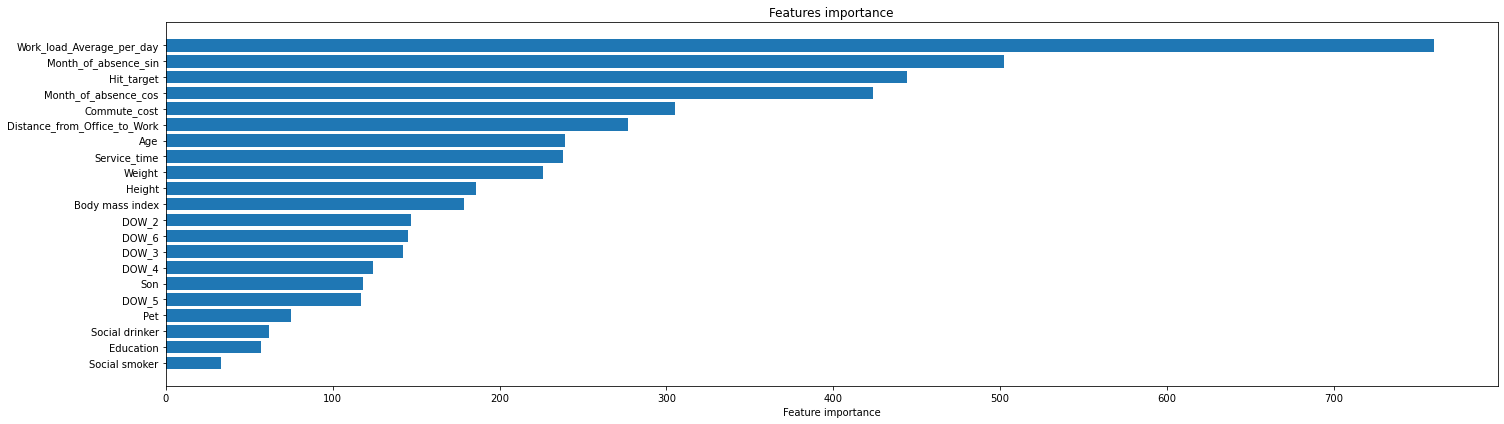

In [32]:
y_plot = -np.arange(21)
plt.figure(figsize=(21,6))
plt.barh(y_plot, features_imp.loc[:20,'importance'].values)
plt.yticks(y_plot,(features_imp.loc[:20,'features']))
plt.xlabel('Feature importance')
plt.title('Features importance')
plt.tight_layout()

Text(0.5, 0, 'False Positive Rate')

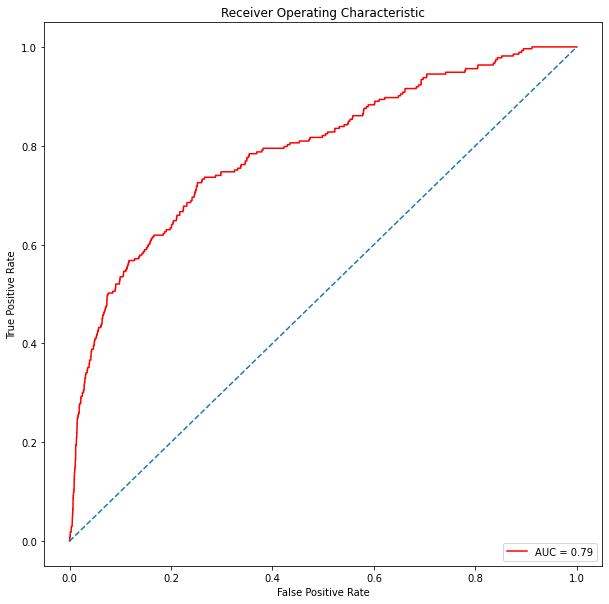

In [33]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, lgb_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [34]:
y_pred = lgb_clf.predict(X_test)

#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)
print(confusion.diagonal()/confusion.sum(axis=1))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

Confusion Matrix

[[7802  619]
 [ 142  131]]
[0.92649329 0.47985348]

Classification Report

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      8421
         1.0       0.17      0.48      0.26       273

    accuracy                           0.91      8694
   macro avg       0.58      0.70      0.60      8694
weighted avg       0.96      0.91      0.93      8694

